# Trident Implementation
- Putting together all the functions for trident.
- To b cleaned later if the code works

In [114]:
import os
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
import optax
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from collections import defaultdict

from sklearn.datasets import make_moons

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [109]:
DATA_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Datasets/"
FIGURES_PATH = f"/Users/vikrantjaltare/Documents/GitHub/TriDeNT/Figures"

# Network initialization

In [4]:
## initialize layers
def init_network_params(input_shape, output_shape, key = jax.random.key(0)):
    """
    Xavier initialization of weights and zeros for biases
    """

    key, param_key = jax.random.split(key)

    W = jax.random.normal(param_key, (output_shape, input_shape)) * jnp.sqrt(2/(input_shape + output_shape))
    b = jnp.zeros(output_shape)

    return W, b

## initialize network layers
def init_network_layers(sizes, key = jax.random.key(0)):
    """
    Initialize W and b for each layer. 
    sizes is a list of fc units
    """
    keys = jax.random.split(key, len(sizes))
    params = [init_network_params(n_in, n_out, key) for n_in, n_out, key in zip(sizes[:-1], sizes[1:], keys)]
    return params


# Activation function

In [5]:
## define ternary thresholding activation function
def ternary_activation(x, thresholds, noise_sd, key):
    """
    Ternary activation function
    """
    # key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key = key, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise


    # threshold
    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s

## define binary thresholding function: states [-1, 1]
def binary_activation(x, threshold, noise_sd, key):
    """
    Binary activation function
    """
    # key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise

    s = jnp.where(
        x < threshold, 0.0, 1.0
    )

    return s


# Custom backward pass through expected state gradient

In [15]:
## helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)

@jax.jit
def expected_state(x, thresholds, noise_sd):
    t1, t2 = thresholds
    e = ((1 - gaussian_cdf(x = t2 - x, mu = 0, sigma = noise_sd)) - gaussian_cdf(x = t1 - x, mu = 0, sigma = noise_sd))
    return e

# custom gradients

@jax.custom_vjp
def custom_ternary_gradient(x, thresholds, noise_sd, key):
    return ternary_activation(x = x, thresholds = thresholds, noise_sd = noise_sd, key = key) # call the ternary activation in the forward pass

def custom_ternary_gradient_fwd(x, thresholds, noise_sd, key):
    return custom_ternary_gradient(x, thresholds, noise_sd, key), (x, thresholds, noise_sd) # save the inputs, thresholds, noise_sd for the backward pass

def custom_ternary_gradients_bwd(residuals, grads):
    x, thresholds, noise_sd = residuals # unpack the residuals from forward pass
    t1, t2 = thresholds
    exp_state_grad = gaussian_pdf(x = t1 - x, mu = 0, sigma = noise_sd) + gaussian_pdf(x = t2 - x, mu = 0, sigma = noise_sd)
    return (exp_state_grad*grads, None, None, None)

custom_ternary_gradient.defvjp(custom_ternary_gradient_fwd, custom_ternary_gradients_bwd)

Text(0, 0.5, 'Custom Gradient')

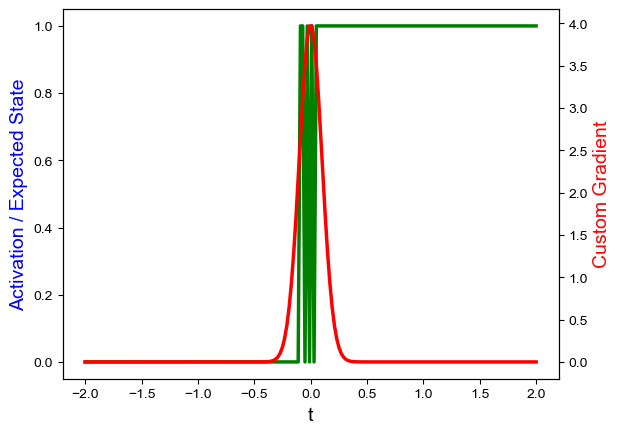

In [11]:
## cuatom gradient for binary activation

@jax.custom_vjp
def custom_binary_gradient(x, threshold, noise_sd, key):
    return binary_activation(x = x, threshold = threshold, noise_sd = noise_sd, key = key)

def custom_binary_gradient_fwd(x, threshold, noise_sd, key):
    return custom_binary_gradient(x, threshold, noise_sd, key), (x, threshold, noise_sd)

def custom_binary_gradient_bwd(residuals, gradients):
    x, threshold, noise_sd = residuals
    grad = gaussian_pdf(x = x - threshold, mu = 0, sigma = noise_sd)
    return (grad*gradients, None, None, None)

custom_binary_gradient.defvjp(custom_binary_gradient_fwd, custom_binary_gradient_bwd)


## plotting
t = jnp.linspace(-2, 2, 200)
nsd = 0.1
kk = jax.random.key(0)
b_act = custom_binary_gradient(t, 0, nsd, kk)
b_grad = jax.vmap(jax.grad(custom_binary_gradient), in_axes=(0, None, None, None))(t, 0, nsd, kk)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t, b_act, 'g-', lw = 2.5)
# ax1.plot(t, exp_st, 'b-', lw = 2.5)
ax2.plot(t, b_grad, 'r-', lw = 2.5)

ax1.set_xlabel('t', fontsize = 14)
ax1.set_ylabel('Activation / Expected State', color='b', fontsize = 14)
ax2.set_ylabel('Custom Gradient', color='r', fontsize = 14)

## trial plot
# t = jnp.linspace(-2, 2, 200)
# b_cdf = gaussian_cdf(t, 0, 0.1)
# exp_s = 2*b_cdf - 1
# exp_s_grad = 2*gaussian_pdf(t, 0, 0.1)
# bin_act = binary_activation(t, 0, 0.1)

# plt.plot(t, exp_s)
# plt.plot(t, exp_s_grad)
# plt.plot(t, bin_act)
# plt.show()

Text(0, 0.5, 'Custom Gradient')

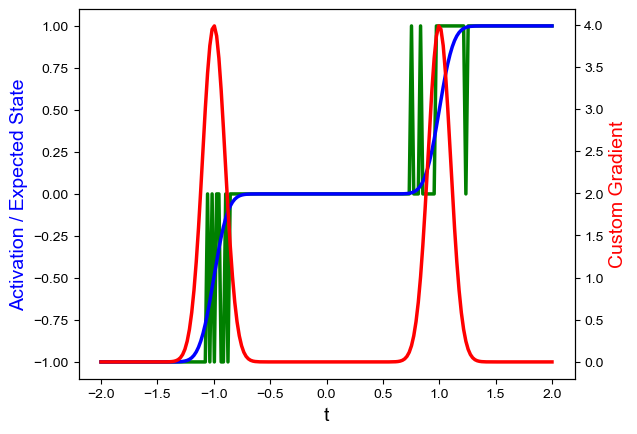

In [16]:
## testing
t = jnp.linspace(-2, 2, 200)
th = [-1.0, 1.0]
noise_sd = 0.1
act = ternary_activation(t, th, 0.1, kk)
exp_st = expected_state(t, th, noise_sd)
cus_grad = jax.vmap(jax.grad(custom_ternary_gradient), in_axes=(0, None, None, None))(t, th, noise_sd, kk)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t, act, 'g-', lw = 2.5)
ax1.plot(t, exp_st, 'b-', lw = 2.5)
ax2.plot(t, cus_grad, 'r-', lw = 2.5)

ax1.set_xlabel('t', fontsize = 14)
ax1.set_ylabel('Activation / Expected State', color='b', fontsize = 14)
ax2.set_ylabel('Custom Gradient', color='r', fontsize = 14)

# Forward pass, loss, updating parameters

In [28]:
## forward pass
def forward_ternary(params, input, thresholds, noise_sd, key):
    """
    Perform a forward pass through the network
    """

    activations = input
    act_hidden = []

    for i, (W, b) in enumerate(params[:-1]): # iterate through all layers except the last one
        key, split_key = jax.random.split(key)

        # linear transformation
        out = jnp.dot(W, activations) + b

        # pass through non-linearity
        activations = custom_ternary_gradient(out, thresholds, noise_sd, key)
        act_hidden.append(activations)

    # last layer
    W, b = params[-1]
    logits = jnp.dot(W, activations) + b
    # print(f"Hidden activations = {act_hidden}")
    return logits

## forward pass
def forward_binary(params, input, threshold, noise_sd, key):
    """
    Perform a forward pass through the network
    """

    activations = input
    act_hidden = []

    for i, (W, b) in enumerate(params[:-1]): # iterate through all layers except the last one
        key, split_key = jax.random.split(key)

        # linear transformation
        out = jnp.dot(W, activations) + b

        # pass through non-linearity
        activations = custom_binary_gradient(out, threshold, noise_sd, key)
        act_hidden.append(activations)

    # last layer
    W, b = params[-1]
    logits = jnp.dot(W, activations) + b
    # print(f"Hidden activations = {act_hidden}")
    return logits




# using vmap for batched predictions
batch_forward_ternary = vmap(forward_ternary, in_axes = (None, 0, None, None, 0))

batch_forward_binary = vmap(forward_binary, in_axes = (None, 0, None, None, 0))


## loss function
def cross_entropy_loss(params, inputs, targets, thresholds, noise_sd, key):
    """
    Compute cross-entropy loss.
    Assume that labels are one-hot encoded
    """

    # run the forward pass
    logits = batch_forward_ternary(params, inputs, thresholds, noise_sd, key)

    # compute the softmax
    log_probits = jax.nn.log_softmax(logits)

    # compute the cross-entropy
    loss = -jnp.sum(log_probits * targets)

    # TODO: Add regularization

    return jnp.mean(loss)

## loss function
def cross_entropy_loss_binary(params, inputs, targets, threshold, noise_sd, key):
    """
    Compute cross-entropy loss.
    Assume that labels are one-hot encoded
    """

    # run the forward pass
    logits = batch_forward_binary(params, inputs, threshold, noise_sd, key)

    # compute the softmax
    log_probits = jax.nn.log_softmax(logits)

    # compute the cross-entropy
    loss = -jnp.sum(log_probits * targets)

    # TODO: Add regularization

    return jnp.mean(loss)

In [30]:
## Testing cell
## test the forward pass: Uncomment to test!
example_input = jax.random.normal(key = jax.random.key(0), shape = (10, 5)) # dim: (num_batches x num_inputs)
example_params = init_network_layers([5, 10, 2])
example_thresholds = [-1.0, 1.0]
example_noise_sd = 0.1
example_key = jax.random.key(0)
example_keys = jax.random.split(example_key, example_input.shape[0])
# # example_forward = predict(example_params, example_input, example_thresholds, example_noise_sd, activation = 'ternary')
# trace_predict = jax.make_jaxpr(batch_forward_ternary)(example_params, example_input, example_thresholds, example_noise_sd)
# # print(trace_predict)
# print(forward_ternary(example_params, example_input[5], example_thresholds, example_noise_sd))
oo = batch_forward_ternary(example_params, example_input, example_thresholds, example_noise_sd, example_keys)
print(oo)
# print(jax.nn.softmax(oo))

# test the loss function
example_targets = jax.random.randint(minval=0, maxval=2, shape = (10, 2), key = jax.random.key(0))
example_loss = cross_entropy_loss(example_params, example_input, example_targets, example_thresholds, example_noise_sd, example_keys)
example_grad = jax.grad(cross_entropy_loss)(example_params, example_input, example_targets, example_thresholds, example_noise_sd, example_keys)
print(f"Loss: {example_loss}")
for i, (gw, gb) in enumerate(example_grad):
    print(f"Layer = {i + 1} \n")
    print(f"Gradient W: {gw}, Gradient b: {gb}")
print(example_targets)

[[ 0.82240325  0.31659925]
 [ 0.4106468  -0.9141994 ]
 [-0.9523988   0.17070237]
 [ 0.59727687 -0.05963686]
 [-0.9523988   0.17070237]
 [-1.4047631   0.83299685]
 [ 0.          0.        ]
 [ 0.45236433 -0.6622945 ]
 [-0.9523988   0.17070237]
 [ 0.82240325  0.31659925]]
Loss: 5.2337799072265625
Layer = 1 

Gradient W: [[ 1.66480250e-11  1.55792081e-11 -4.32354812e-11 -7.92341366e-12
   8.49280785e-11]
 [ 5.16825622e-08  1.63803563e-07 -8.60327489e-08 -1.12852561e-07
   2.86900814e-07]
 [-3.69984627e-01 -1.58453798e+00  1.77497510e-02 -1.12509334e+00
  -4.93788749e-01]
 [ 6.48139112e-11  4.69765199e-11  7.48611156e-12 -3.20032672e-12
   2.58524330e-11]
 [-2.93911487e-01 -9.29310322e-01  4.93777156e-01  6.42806172e-01
  -1.63551486e+00]
 [ 1.42756134e-01 -7.99767300e-02 -4.60005105e-01  9.52511057e-02
   6.85379028e-01]
 [-2.75257993e-02  2.02168096e-02  9.07012969e-02 -2.20307615e-02
  -1.31189868e-01]
 [-5.39052904e-01 -1.81549358e+00  8.23308527e-01  8.97020996e-02
  -2.30969167e+00]


In [105]:
print(jnp.argmax(oo, axis = 1))

[0 0 1 0 1 1 0 0 1 0]


# Loading data
- Import MNIST using tensoflow datasets

In [81]:
# tf.config.set_visible_devices([], device_type='GPU')

# # mention the batch_size
# batch_size = 128

# mnist_data, info = tfds.load(name="mnist", 
#                              batch_size = batch_size,
#                              data_dir=DATA_PATH, 
#                              with_info=True)

# mnist_data = tfds.as_numpy(mnist_data)

# # Extract train and test data
# train_data, test_data = mnist_data['train'], mnist_data['test']

# # Combine train and test data
# images = np.concatenate([train_data['image'], test_data['image']], axis=0)
# labels = np.concatenate([train_data['label'], test_data['label']], axis=0)

# # extract the number of pixels
# num_pixels = images.shape[1]*images.shape[2]

# # Shuffle the data
# indices = np.arange(images.shape[0])
# np.random.shuffle(indices)
# images = images[indices]
# labels = labels[indices]

# # Split the data
# train_images, train_labels = images[:50000], labels[:50000]
# train_images = jnp.reshape(train_images, (train_images.shape[0], num_pixels))
# valid_images, valid_labels = images[50000:60000], labels[50000:60000]
# valid_images = jnp.reshape(valid_images, (valid_images.shape[0], num_pixels))
# test_images, test_labels = images[60000:], labels[60000:]
# test_images = jnp.reshape(test_images, (test_images.shape[0], num_pixels))

# print(f"Train set: {train_images.shape}, {train_labels.shape}")
# print(f"Validation set: {valid_images.shape}, {valid_labels.shape}")
# print(f"Test set: {test_images.shape}, {test_labels.shape}")


In [31]:
BATCH_SIZE = 128

def load_and_preprocess_mnist(data_path, batch_size, binarize = False):
    """
    load mnist with splits and normalize
    """

    ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], data_dir=data_path, as_supervised=True)

    # normalize and convert to numpy
    def normalize_image(image, label):
        image = tf.cast(image, tf.float32)/ 255.0

        if binarize:
            image = tf.where(image < 0.5, 0.0, 1.0)

        return image, label
    
    ds_train = ds_train.map(normalize_image)
    ds_test = ds_test.map(normalize_image)

    # convert to numpy
    train_data = tfds.as_numpy(ds_train)
    test_data = tfds.as_numpy(ds_test)

    # separate images and samples
    train_images, train_labels = zip(*train_data)
    test_images, test_labels = zip(*test_data)

    # convert tuples to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # concatenate to create a single dataset
    images = np.concatenate([train_images, test_images], axis = 0)
    labels = np.concatenate([train_labels, test_labels], axis = 0)

    # split the data 50k-10k-10k
    train_images, val_images, test_images = images[:50000], images[50000:60000], images[60000:]
    train_labels, val_labels, test_labels = labels[:50000], labels[50000:60000], labels[60000:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

def get_train_batches(train_images, train_labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    ds = ds.shuffle(len(train_images)).batch(batch_size).prefetch(1)
    return tfds.as_numpy(ds)


# load the data
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_and_preprocess_mnist(DATA_PATH, BATCH_SIZE, binarize = True)

print(train_images.shape)
print(train_images[0].reshape(-1, 28))

(50000, 28, 28, 1)
[[[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]


(-0.5, 27.5, 27.5, -0.5)

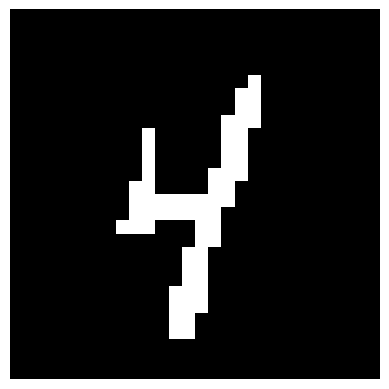

In [118]:
plt.imshow(train_images[0].reshape(-1, 28), cmap = 'gray')
plt.axis('off')

## Helper functions

In [34]:
## define an accuracy function for ternary case
def accuracy(params, images, targets, thresholds, keys, noise_sd):
    """
    Calculate the accuracy of the model
    """
    # target_class = jnp.argmax(targets, axis = 1)
    # batch_forward_ternary(example_params, example_input, example_thresholds, example_noise_sd)
    pred = batch_forward_ternary(params, images, thresholds, noise_sd, keys)
    pred = jnp.argmax(pred, axis = 1)
    # predicted_class = jnp.argmax(batch_forward_ternary(params, images, thresholds, key, noise_sd), axis = 1)
    mean_acc = jnp.mean(pred == targets)
    # print(pred, mean_acc)


    return mean_acc

## define an accuracy function for binary case
def accuracy_binary(params, images, targets, threshold, keys, noise_sd):
    """
    Calculate the accuracy of the model
    """
    # target_class = jnp.argmax(targets, axis = 1)
    # batch_forward_ternary(example_params, example_input, example_thresholds, example_noise_sd)
    pred = batch_forward_binary(params, images, threshold, noise_sd, keys)
    pred = jnp.argmax(pred, axis = 1)
    # predicted_class = jnp.argmax(batch_forward_ternary(params, images, thresholds, key, noise_sd), axis = 1)
    mean_acc = jnp.mean(pred == targets)
    # print(pred, mean_acc)


    return mean_acc

## choose an optimizer
lr = 1e-3
optimizer = optax.sgd(learning_rate=1e-3)

def update_with_sgd(params, image, label, thresholds, noise_sd, keys, opt_state):
  # compute gradients and update parameters
  loss, grads = jax.value_and_grad(cross_entropy_loss)(params, image, label, thresholds, noise_sd, keys)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

def update_with_sgd_binary(params, image, label, thresholds, noise_sd, keys, opt_state):
  # compute gradients and update parameters
  loss, grads = jax.value_and_grad(cross_entropy_loss_binary)(params, image, label, thresholds, noise_sd, keys)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

In [11]:
# testing acuraracy
example_targets = jax.random.randint(minval=0, maxval=2, shape = example_input.shape[0], key = jax.random.key(0))
print(example_targets)
aa = accuracy(example_params, example_input, example_targets, example_thresholds, 100, example_noise_sd)

[0 1 1 0 1 1 0 1 0 0]


In [86]:
# testing binary activations
ff = forward_binary(example_params, example_input[5], 0, example_noise_sd)
print(ff)

[-0.7247895  -0.18207324]


# Training loop

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Train Acc: 0.09925999492406845, Valid Acc: 0.09589999914169312
Epoch 1, Train Acc: 0.11225999891757965, Valid Acc: 0.11289999634027481
Epoch 2, Train Acc: 0.1122799962759018, Valid Acc: 0.11289999634027481
Epoch 3, Train Acc: 0.20943999290466309, Valid Acc: 0.2069999873638153
Epoch 4, Train Acc: 0.8541799783706665, Valid Acc: 0.8533999919891357
Epoch 5, Train Acc: 0.9285599589347839, Valid Acc: 0.9199000000953674
Epoch 6, Train Acc: 0.9529199600219727, Valid Acc: 0.9351999759674072
Epoch 7, Train Acc: 0.964419960975647, Valid Acc: 0.9477999806404114
Epoch 8, Train Acc: 0.9709599614143372, Valid Acc: 0.9524999856948853
Epoch 9, Train Acc: 0.9755599498748779, Valid Acc: 0.9545999765396118


Text(0, 0.5, 'Accuracy')

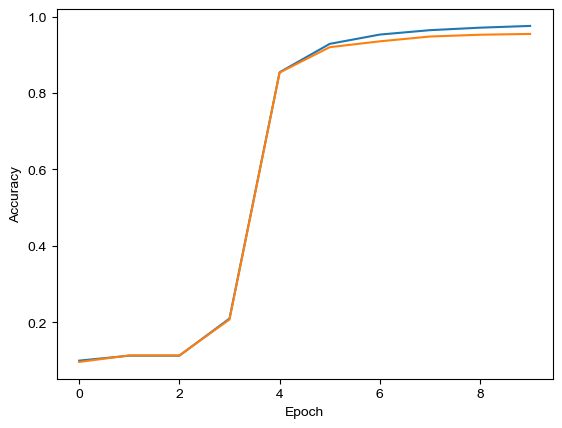

In [38]:
num_epochs = 10
num_pixels = 28*28
num_labels = 10
sizes = [num_pixels, 1028, 1028, num_labels]
key = jax.random.key(0)
net_params = init_network_layers(sizes, key)
thresholds = [-1.0, 1.0]
noise_sd = 0.1
opt_state = optimizer.init(net_params)
BATCH_SIZE = 128

# keep track of accuracies
train_accs = []
valid_accs = []
train_loss = []


for epoch in tqdm(range(num_epochs)):
    # generate train a valid keys
    train_keys = jax.random.split(key, len(train_images))
    valid_keys = jax.random.split(key, len(val_images))

    # print accuracies on train and validation
    train_acc = accuracy(net_params, train_images.reshape(-1, num_pixels), train_labels, thresholds, train_keys, noise_sd*0)
    valid_acc = accuracy(net_params, val_images.reshape(-1, num_pixels), val_labels, thresholds, valid_keys, noise_sd*0)
    print(f"Epoch {epoch}, Train Acc: {train_acc}, Valid Acc: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    # get the batches!!
    for image, label in get_train_batches(train_images, train_labels, BATCH_SIZE):
        # generate a batch key
        batch_keys = jax.random.split(key, len(image))
        
        image = jnp.reshape(image, (len(image), num_pixels))
        y = jax.nn.one_hot(label, num_labels)
        net_params, opt_state, loss = update_with_sgd(net_params, image, y, thresholds, noise_sd, batch_keys, opt_state)
        train_loss.append(loss)
        # print(f"Train loss: {loss}")


## plot the accuracies
plt.plot(train_accs, label = 'Train Accuracy')
plt.plot(valid_accs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')





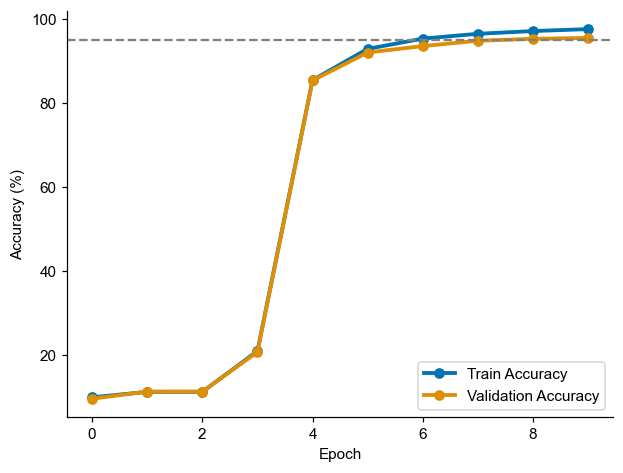

In [39]:
## neater plots
pal_cb = sns.color_palette('colorblind', 8)
fig, ax = plt.subplots(dpi = 110)
ax.plot([a * 100 for a in (train_accs)], label = 'Train Accuracy', c = pal_cb[0], lw = 2.5, marker = 'o')
ax.plot([a * 100 for a in (valid_accs)], label = 'Validation Accuracy', c = pal_cb[1], lw = 2.5, marker = 'o')
ax.axhline(y = 0.95*100, c = 'grey', ls = '--', lw = 1.5)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.legend()

sns.despine()

In [40]:
## print the test set accuracy
test_keys = jax.random.split(key, len(test_images))
test_acc = accuracy(net_params, test_images.reshape(-1, num_pixels), test_labels, thresholds, test_keys, noise_sd*0)
print(f"Test-set accuracy = {test_acc*100:.2f}%")

Test-set accuracy = 95.33%


## Binary Network

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Train Acc: 0.09173999726772308, Valid Acc: 0.09669999778270721
Epoch 1, Train Acc: 0.9424799680709839, Valid Acc: 0.9359999895095825
Epoch 2, Train Acc: 0.9662599563598633, Valid Acc: 0.9536999464035034
Epoch 3, Train Acc: 0.9788599610328674, Valid Acc: 0.9596999883651733
Epoch 4, Train Acc: 0.9830999970436096, Valid Acc: 0.9619999527931213
Epoch 5, Train Acc: 0.9910399913787842, Valid Acc: 0.9667999744415283
Epoch 6, Train Acc: 0.9952600002288818, Valid Acc: 0.9698999524116516
Epoch 7, Train Acc: 0.9975199699401855, Valid Acc: 0.9716999530792236
Epoch 8, Train Acc: 0.9983599781990051, Valid Acc: 0.9731999635696411
Epoch 9, Train Acc: 0.9992199540138245, Valid Acc: 0.972599983215332


Text(0, 0.5, 'Accuracy')

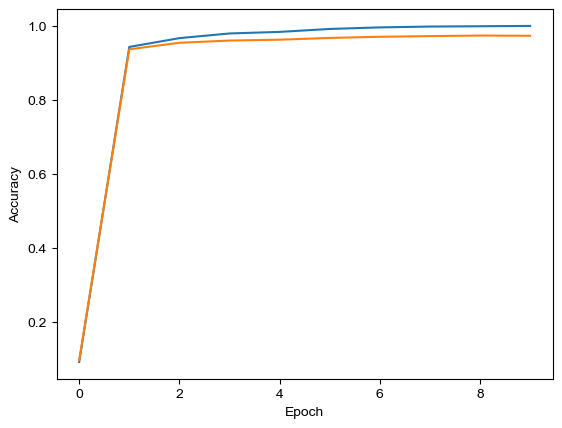

In [111]:
num_epochs = 10
num_pixels = 28*28
num_labels = 10
sizes = [num_pixels, 2000, 1000, num_labels]
key = jax.random.key(1)
net_params = init_network_layers(sizes, key)
threshold = 0.0
noise_sd = 0.1
opt_state = optimizer.init(net_params)
BATCH_SIZE = 128

# keep track of accuracies
train_accs = []
valid_accs = []
train_loss = []


for epoch in tqdm(range(num_epochs)):
    # generate train a valid keys
    train_keys = jax.random.split(key, len(train_images))
    valid_keys = jax.random.split(key, len(val_images))

    # print accuracies on train and validation
    train_acc = accuracy_binary(net_params, train_images.reshape(-1, num_pixels), train_labels, threshold, train_keys, noise_sd*0)
    valid_acc = accuracy_binary(net_params, val_images.reshape(-1, num_pixels), val_labels, threshold, valid_keys, noise_sd*0)
    print(f"Epoch {epoch}, Train Acc: {train_acc}, Valid Acc: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    # get the batches!!
    for image, label in get_train_batches(train_images, train_labels, BATCH_SIZE):
        # generate a batch key
        batch_keys = jax.random.split(key, len(image))
        image = jnp.reshape(image, (len(image), num_pixels))
        y = jax.nn.one_hot(label, num_labels)
        net_params, opt_state, loss = update_with_sgd_binary(net_params, image, y, threshold, noise_sd, batch_keys, opt_state)
        train_loss.append(loss)
        # print(f"Train loss: {loss}")


## plot the accuracies
plt.plot(train_accs, label = 'Train Accuracy')
plt.plot(valid_accs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


In [112]:
## print the test set accuracy
# make test keys
test_keys = jax.random.split(key, len(test_images))
test_acc = accuracy_binary(net_params, test_images.reshape(-1, num_pixels), test_labels, threshold, test_keys, noise_sd*0)
print(f"Test-set accuracy = {test_acc*100:.2f}%")

Test-set accuracy = 97.46%


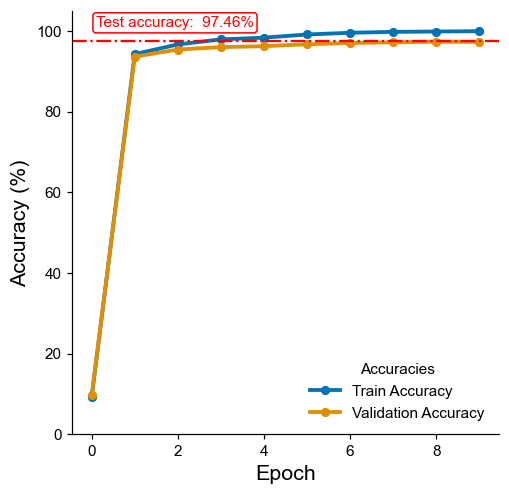

In [115]:
## neater plots
pal_cb = sns.color_palette('colorblind', 8)
fig, ax = plt.subplots(dpi = 110, figsize = (5, 5))
ax.plot([a * 100 for a in (train_accs)], label = 'Train Accuracy', c = pal_cb[0], lw = 2.5, marker = 'o', markersize = 5)
ax.plot([a * 100 for a in (valid_accs)], label = 'Validation Accuracy', c = pal_cb[1], lw = 2.5, marker = 'o', markersize = 5)
ax.axhline(y = test_acc*100, c = 'r', ls = '-.', lw = 1.5)

ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel('Accuracy (%)', fontsize = 14)
ax.legend(frameon = False, title = "Accuracies")
ax.text(x = 0.1, y = 101, s = f"Test accuracy: {test_acc * 100: .02f}%", color = 'r', bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.2'))
ax.set_ylim(0, 105)


sns.despine()

# plt.savefig(os.path.join(FIGURES_PATH, "mnist_binary_2k_1k_111724.pdf"), dpi = 300, bbox_inches = 'tight', transparent = True)

# Some more tests...
- Test if all the weights are getting trained.
- Test if the activations in the hidden layer are ternary.

In [160]:
## Test: check if all the weights are trained
num_epochs = 2
num_pixels = 28*28
num_labels = 10
sizes = [num_pixels, 2000, num_labels]
key = jax.random.key(0)
net_params = init_network_layers(sizes, key)
thresholds = [-1.0, 1.0]
noise_sd = 0.1
opt_state = optimizer.init(net_params)

# changes to layerwise params
param_analisys_dict = {
    'delta_weights_output': [],
    'delta_biases_output': [],
    'delta_weights_input': [],
    'delta_biases_input': []
}

last = None


for epoch in tqdm(range(num_epochs)):
    # print accuracies on train and validation
    train_acc = accuracy(net_params, train_images.reshape(-1, num_pixels), train_labels, thresholds, key, noise_sd)
    valid_acc = accuracy(net_params, val_images.reshape(-1, num_pixels), val_labels, thresholds, key, noise_sd)
    print(f"Epoch {epoch}, Train Acc: {train_acc}, Valid Acc: {valid_acc}")
    
    # get the batches!!
    for image, label in get_train_batches(train_images, train_labels, BATCH_SIZE):
        image = jnp.reshape(image, (len(image), num_pixels))
        y = jax.nn.one_hot(label, num_labels)
        net_params, opt_state, loss = update_with_sgd(net_params, image, y, thresholds, noise_sd, opt_state)
        if last is not None:
            param_analisys_dict['delta_weights_output'].append(jnp.linalg.norm(last[1][0] - net_params[1][0]))
            param_analisys_dict['delta_biases_output'].append(jnp.linalg.norm(last[1][1] - net_params[1][1]))
            param_analisys_dict['delta_weights_input'].append(jnp.linalg.norm(last[0][0] - net_params[0][0]))
            param_analisys_dict['delta_biases_input'].append(jnp.linalg.norm(last[0][1] - net_params[0][1]))
            # print(f"Delta Weights output layer {jnp.linalg.norm(last[1][0] - net_params[1][0])}")
            # print(f"Delta biases output layer {jnp.linalg.norm(last[1][1] - net_params[1][1])}")
            # print(f"Delta Weights input layer {jnp.linalg.norm(last[0][0] - net_params[0][0])}")
            # print(f"Delta biases input layer {jnp.linalg.norm(last[0][1] - net_params[0][1])}")



        last = net_params


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Train Acc: 0.06684000045061111, Valid Acc: 0.06520000100135803


KeyboardInterrupt: 

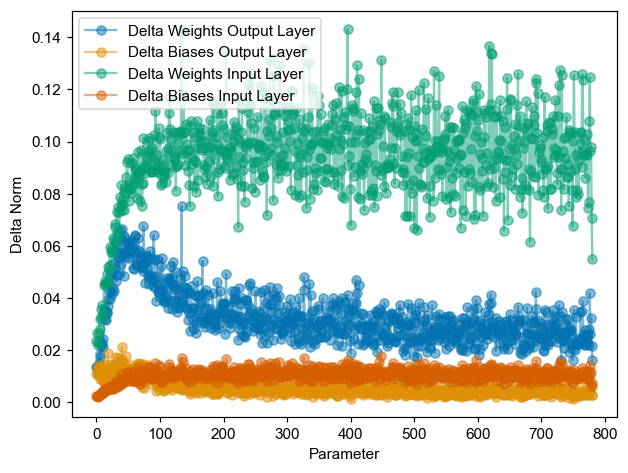

In [147]:
## plot the dict
fig, ax = plt.subplots(dpi = 110)
ax.plot(param_analisys_dict['delta_weights_output'], label = 'Delta Weights Output Layer', c = pal_cb[0], lw = 1.5, marker = 'o', alpha = .5)
ax.plot(param_analisys_dict['delta_biases_output'], label = 'Delta Biases Output Layer', c = pal_cb[1], lw = 1.5, marker = 'o', alpha = .5)
ax.plot(param_analisys_dict['delta_weights_input'], label = 'Delta Weights Input Layer', c = pal_cb[2], lw = 1.5, marker = 'o', alpha = .5)
ax.plot(param_analisys_dict['delta_biases_input'], label = 'Delta Biases Input Layer', c = pal_cb[3], lw = 1.5, marker = 'o', alpha = .5)
ax.set_xlabel("Parameter")
ax.set_ylabel("Delta Norm")
ax.legend()

In [150]:
jnp.linalg.norm(net_params[1][0])

Array(8.03626, dtype=float32)

In [151]:
jnp.linalg.norm(last[1][0] - net_params[1][0])

Array(0., dtype=float32)

# Hyperparameter Tuning
- See the best combo of threesholds, noise_sd and hidden layers

In [15]:
## sweeping noise levels
noise_sd_list = [1e-3, 1e-2, 1e-1, 1e0]

# keeping the rest of the simulation parameters the same
num_epochs = 5
num_pixels = 28*28
num_labels = 10
sizes = [num_pixels, 2048, num_labels]
key = jax.random.key(0)
# net_params = init_network_layers(sizes, key)
thresholds = [-1.0, 1.0]
# opt_state = optimizer.init(net_params)

# keep track of accuracies
train_accs = defaultdict(list)
valid_accs = defaultdict(list)


for noise_sd in noise_sd_list:
    print("-----------------------------")
    print(f"Noise sd {noise_sd}")
    print("-----------------------------")
    net_params = init_network_layers(sizes, key)
    opt_state = optimizer.init(net_params)
    

    for epoch in tqdm(range(num_epochs)):
        # print accuracies on train and validation
        train_acc = accuracy(net_params, train_images.reshape(-1, num_pixels), train_labels, thresholds, key, noise_sd*0) # no noise during inference
        valid_acc = accuracy(net_params, val_images.reshape(-1, num_pixels), val_labels, thresholds, key, noise_sd*0)
        print(f"Epoch {epoch + 1}, Train Acc: {train_acc}, Valid Acc: {valid_acc}")

        train_accs[noise_sd].append(train_acc)
        valid_accs[noise_sd].append(valid_acc)

        for image, label in get_train_batches(train_images, train_labels, BATCH_SIZE):
            image = jnp.reshape(image, (len(image), num_pixels))
            y = jax.nn.one_hot(label, num_labels)
            net_params, opt_state, loss = update_with_sgd(net_params, image, y, thresholds, noise_sd, opt_state)


# ## plot the accuracies
# plt.plot(train_accs, label = 'Train Accuracy')
# plt.plot(valid_accs, label = 'Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')


-----------------------------
Noise sd 0.001
-----------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Acc: 0.07976000010967255, Valid Acc: 0.07739999890327454
Epoch 2, Train Acc: 0.7653200030326843, Valid Acc: 0.7669999599456787
Epoch 3, Train Acc: 0.7404999732971191, Valid Acc: 0.7423999905586243
Epoch 4, Train Acc: 0.7502399682998657, Valid Acc: 0.7458999752998352
Epoch 5, Train Acc: 0.7796399593353271, Valid Acc: 0.7838999629020691
-----------------------------
Noise sd 0.01
-----------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Acc: 0.07976000010967255, Valid Acc: 0.07739999890327454
Epoch 2, Train Acc: 0.876579999923706, Valid Acc: 0.8772000074386597
Epoch 3, Train Acc: 0.897599995136261, Valid Acc: 0.8986999988555908
Epoch 4, Train Acc: 0.9058399796485901, Valid Acc: 0.9052000045776367
Epoch 5, Train Acc: 0.9115599989891052, Valid Acc: 0.9107999801635742
-----------------------------
Noise sd 0.1
-----------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Acc: 0.07976000010967255, Valid Acc: 0.07739999890327454
Epoch 2, Train Acc: 0.9121800065040588, Valid Acc: 0.9103999733924866
Epoch 3, Train Acc: 0.9370599985122681, Valid Acc: 0.9307999610900879
Epoch 4, Train Acc: 0.9495399594306946, Valid Acc: 0.9364999532699585
Epoch 5, Train Acc: 0.9590199589729309, Valid Acc: 0.9435999989509583
-----------------------------
Noise sd 1.0
-----------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Train Acc: 0.07976000010967255, Valid Acc: 0.07739999890327454
Epoch 2, Train Acc: 0.6474399566650391, Valid Acc: 0.6502000093460083
Epoch 3, Train Acc: 0.6128399968147278, Valid Acc: 0.6118999719619751
Epoch 4, Train Acc: 0.5866599678993225, Valid Acc: 0.5884000062942505
Epoch 5, Train Acc: 0.5974599719047546, Valid Acc: 0.597599983215332


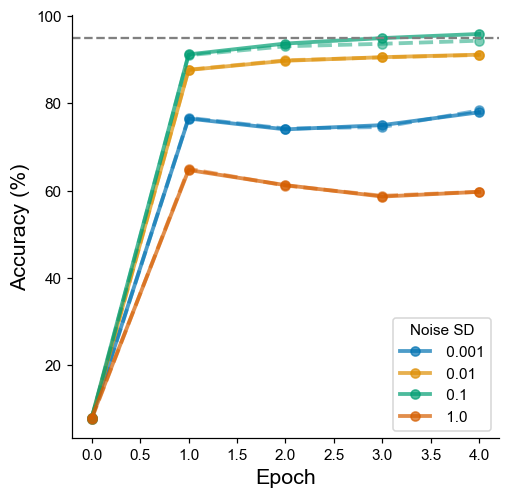

In [27]:
fig, ax = plt.subplots(figsize = (5, 5), dpi = 110)

pal_cb = sns.color_palette('colorblind', 8)

for i, noise_sd in enumerate(train_accs.keys()):
    ax.plot([a * 100 for a in train_accs[noise_sd]], label = f' {noise_sd}', lw = 2.5, marker = 'o', c = pal_cb[i], alpha = .7)
    ax.plot([a * 100 for a in valid_accs[noise_sd]], lw = 2.5, ls = '--', marker = 'o', c = pal_cb[i], alpha = .5)

ax.axhline(y = 0.95*100, c = 'grey', ls = '--', lw = 1.5)
ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel('Accuracy (%)', fontsize = 14)
ax.legend(title = 'Noise SD')

sns.despine()

- Looks like $\sigma \in \{0.01, 0.1\}$ is the better choice for a single layer network.

## Tuning the number of hidden layers

In [53]:
hidden_layer_sizes = [2000, 1000, 800, 700, 500]
layer_sizes = [[num_pixels, h1, h2, num_labels] for h1, h2 in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])]

print(layer_sizes)


[[784, 2000, 1000, 10], [784, 1000, 800, 10], [784, 800, 700, 10], [784, 700, 500, 10]]


Layer sizes:   0%|          | 0/4 [00:00<?, ?it/s]

Testing for sizes [784, 2000, 1000, 10]
Epoch 0, Train Acc: 0.09173999726772308, Valid Acc: 0.09669999778270721
Epoch 1, Train Acc: 0.947219967842102, Valid Acc: 0.9380999803543091
Epoch 2, Train Acc: 0.9650399684906006, Valid Acc: 0.9501000046730042
Epoch 3, Train Acc: 0.9794600009918213, Valid Acc: 0.9592999815940857
Epoch 4, Train Acc: 0.9871999621391296, Valid Acc: 0.9645999670028687
Epoch 5, Train Acc: 0.9912799596786499, Valid Acc: 0.9637999534606934
Epoch 6, Train Acc: 0.9951399564743042, Valid Acc: 0.97079998254776
Epoch 7, Train Acc: 0.9973799586296082, Valid Acc: 0.9722999930381775
Epoch 8, Train Acc: 0.9989399909973145, Valid Acc: 0.9724999666213989
Epoch 9, Train Acc: 0.9992799758911133, Valid Acc: 0.9714999794960022
Testing for sizes [784, 1000, 800, 10]
Epoch 0, Train Acc: 0.1081399992108345, Valid Acc: 0.10610000044107437
Epoch 1, Train Acc: 0.9458199739456177, Valid Acc: 0.9352999925613403
Epoch 2, Train Acc: 0.9558599591255188, Valid Acc: 0.939300000667572
Epoch 3, Tra

Text(0, 0.5, 'Accuracy')

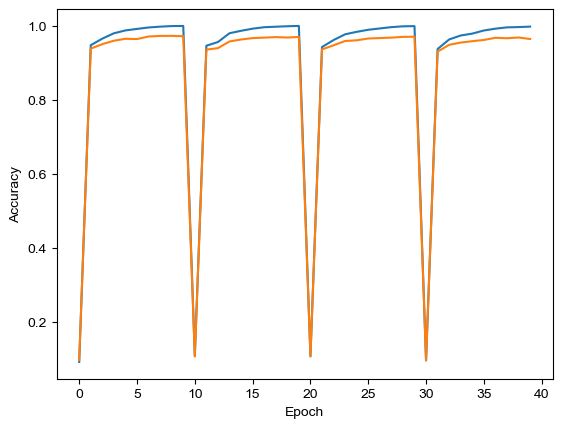

In [108]:
num_epochs = 10
num_pixels = 28*28
num_labels = 10
key = jax.random.key(1)
bs = 64

# keep track of accuracies
train_accs = []
valid_accs = []
train_loss = []

train_acc_dict = defaultdict(list)
valid_acc_dict = defaultdict(list)
train_loss_dict = defaultdict(list)


for i, sizes in enumerate(tqdm(layer_sizes, desc = 'Layer sizes')):
    print(f"Testing for sizes {sizes}")
    net_params = init_network_layers(sizes, key)
    threshold = 0.0
    noise_sd = 0.1
    opt_state = optimizer.init(net_params)

    for epoch in range(num_epochs):
        # generate train a valid keys
        train_keys = jax.random.split(key, len(train_images))
        valid_keys = jax.random.split(key, len(val_images))

        # print accuracies on train and validation
        train_acc = accuracy_binary(net_params, train_images.reshape(-1, num_pixels), train_labels, threshold, train_keys, noise_sd*0)
        valid_acc = accuracy_binary(net_params, val_images.reshape(-1, num_pixels), val_labels, threshold, valid_keys, noise_sd*0)
        print(f"Epoch {epoch}, Train Acc: {train_acc}, Valid Acc: {valid_acc}")

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        # get the batches!!
        for image, label in get_train_batches(train_images, train_labels, bs):
            # generate a batch key
            batch_keys = jax.random.split(key, len(image))
            image = jnp.reshape(image, (len(image), num_pixels))
            y = jax.nn.one_hot(label, num_labels)
            net_params, opt_state, loss = update_with_sgd_binary(net_params, image, y, threshold, noise_sd, batch_keys, opt_state)
            train_loss.append(loss)
            # print(f"Train loss: {loss}")

    train_acc_dict[i].append(train_accs)
    valid_acc_dict[i].append(valid_accs)


## plot the accuracies
plt.plot(train_accs, label = 'Train Accuracy')
plt.plot(valid_accs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


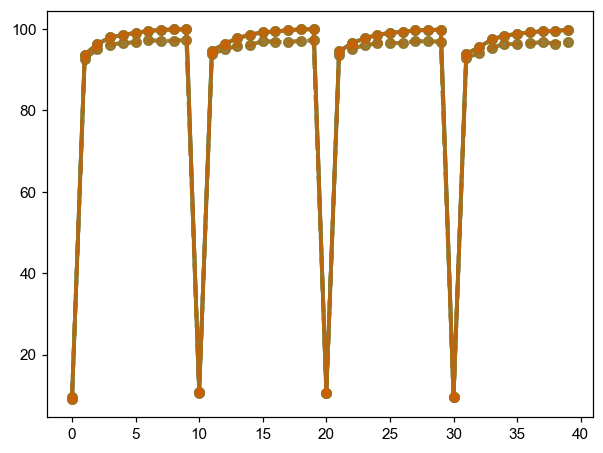

In [59]:
fig, ax = plt.subplots(dpi = 110)
pal_cb = sns.color_palette('colorblind', 8)

for i, sizes in enumerate(layer_sizes):
